# **Ticket Yoda Neural Net - Capstone**

---






In [0]:
#Import stuff

import tensorflow as tf
import pandas as pd
!pip install --upgrade -q gspread
from google.colab import auth
import numpy as np
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt

#Additional Libraries
from keras.models import Sequential
from keras.layers import Embedding
from keras.layers.core import Dense, Activation, Dropout
from keras import optimizers
from sklearn.preprocessing import MinMaxScaler

# Code to read csv file into Colaboratory:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
from google.colab import files
import numpy as np
from scipy import stats
import io

# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)


In [0]:
#Import the Data

id='1bcu2TSWXPFedsnmQV2BppNpnMU6YC6Qv' # The id File
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('FINAL_MASTER.csv')  
df = pd.read_csv('FINAL_MASTER.csv')

df.head()

,artist,date,weekday,promoter,SG_venue,venue_city,venue_state,TM_max,SG_max_price,TM_min,...,daystoconcert,segment,genre,subGenre,Capture_date,SG_listing_count,SG_venue_score,max_pop,max_follow,SG_artists_score
0,Lake Street Dive,1/15/2019,Tuesday,PROMOTED BY VENUE,Ponte Vedra Concert Hall,Ponte Vedra Beach,FL,34.5,36.0,34.5,...,0,Music,Rock,Alternative Rock,1/15/2019,3,0.466979,64,191086,0.56
1,Mineral,1/16/2019,Wednesday,LIVE NATION MUSIC,Theatre of Living Arts,Philadelphia,PA,25.0,109.0,25.0,...,1,Music,Rock,Alternative Rock,1/15/2019,35,0.503499,41,19707,0.39
2,Mineral,1/16/2019,Wednesday,LIVE NATION MUSIC,Theatre of Living Arts,Philadelphia,PA,25.0,68.0,25.0,...,0,Music,Rock,Alternative Rock,1/16/2019,5,0.503499,41,19746,0.39
3,Dylan Scott,1/17/2019,Thursday,LIVE NATION MUSIC,Gramercy Theatre,New York,NY,50.5,286.0,30.5,...,2,Music,Country,Country,1/15/2019,14,0.515187,66,372825,0.49
4,Vertical Horizon,1/17/2019,Thursday,PROMOTED BY VENUE,Highline Ballroom,New York,NY,75.0,217.0,35.0,...,2,Music,Rock,Alternative Rock,1/15/2019,10,0.506355,56,184769,0.42


In [0]:
#change numeric columns to numeric type

df["SG_artists_score"] = pd.to_numeric(df["SG_artists_score"])
df["SG_venue_score"] = pd.to_numeric(df["SG_venue_score"])
df["max_pop"] = pd.to_numeric(df["max_pop"])
df["max_follow"] = pd.to_numeric(df["max_follow"])
df["daystoconcert"] = pd.to_numeric(df["daystoconcert"])
df["SG_average_price"] = pd.to_numeric(df["SG_average_price"])

#Change text object to String

df[["promoter", "genre","subGenre","SG_venue_city","SG_venue_state"]] = df[["promoter", "genre","subGenre","venue_city","venue_state"]].astype(str) 

#check that the types are correct
df.describe()
df.dtypes




artist               object
date                 object
weekday              object
promoter             object
SG_venue             object
venue_city           object
venue_state          object
TM_max              float64
SG_max_price        float64
TM_min              float64
SG_min_price        float64
SG_average_price    float64
daystoconcert         int64
segment              object
genre                object
subGenre             object
Capture_date         object
SG_listing_count      int64
SG_venue_score      float64
max_pop               int64
max_follow            int64
SG_artists_score    float64
SG_venue_city        object
SG_venue_state       object
dtype: object

In [0]:
#Import tensor flow
from __future__ import absolute_import, division, print_function

import pathlib
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

1.13.1


# Data Cleaning/Setup


In [0]:
##Removing rows accordingly to our data cleaning process
#Remove max popularity < 10
#Remove max followers <10
#Remove data points with average price > 300 (IQR 0.75 - 0.25 + Mean)
#Drop any lines with NA, None
#Remove venue score 0 and artist score 0

df = df[df['SG_average_price'] > 0]

df=df[df['SG_average_price'] <= 400]

df=df[df['max_pop'] >=10]

df=df[df['max_follow'] >=10]

df=df[df['SG_venue_score'] >=0.1]

df=df[df['SG_artists_score'] >=0.1]

#drop NAs
df = df.dropna()






In [0]:
#create subset only with the variables that we are going to use in the model

X = df[['SG_artists_score',
'SG_venue_city',
'SG_venue_score',
'SG_venue_state',
'max_pop',
'max_follow',
'daystoconcert',
'subGenre',
'weekday',
'promoter',
'SG_average_price']]



In [0]:
#One Hot! encoding

dummies1 = pd.get_dummies(df['promoter'])
X= pd.concat([X,dummies1],axis=1)

dummies3 = pd.get_dummies(df['subGenre'])
X= pd.concat([X,dummies3],axis=1)

dummies4 = pd.get_dummies(df['SG_venue_city'])
X= pd.concat([X,dummies4],axis=1)

dummies5 = pd.get_dummies(df['SG_venue_state'])
X= pd.concat([X,dummies5],axis=1)

dummies6 = pd.get_dummies(df['weekday'])
X= pd.concat([X,dummies6],axis=1)

In [0]:
#Drop columns that will be unused

X.drop(columns=['promoter', 'subGenre','SG_venue_city','SG_venue_state','weekday' ], inplace=True)


In [0]:
#Split the dataset into test and train
train_dataset = X.sample(frac=0.8,random_state=0)
test_dataset = X.drop(train_dataset.index)


In [0]:
train_stats = train_dataset.describe()
train_stats.pop('SG_average_price')
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
SG_artists_score,9489.0,0.497341,0.068753,0.300000,0.450000,0.490000,0.530000,8.600000e-01
SG_venue_score,9489.0,0.538494,0.093804,0.314276,0.466979,0.528636,0.589911,8.455254e-01
max_pop,9489.0,58.048266,14.018394,10.000000,51.000000,61.000000,67.000000,9.600000e+01
max_follow,9489.0,422560.591632,974310.265158,28.000000,36351.000000,144396.000000,429323.000000,1.094470e+07
daystoconcert,9489.0,52.100854,30.768858,0.000000,27.000000,49.000000,75.000000,1.360000e+02
191 TOURING,9489.0,0.000105,0.010266,0.000000,0.000000,0.000000,0.000000,1.000000e+00
AEG - TICKETING,9489.0,0.000211,0.014517,0.000000,0.000000,0.000000,0.000000,1.000000e+00
AEG LIVE,9489.0,0.010749,0.103125,0.000000,0.000000,0.000000,0.000000,1.000000e+00
AL WASH,9489.0,0.000105,0.010266,0.000000,0.000000,0.000000,0.000000,1.000000e+00
ANDREW HEWITT & BILL SILVA PRESENTS,9489.0,0.001159,0.034030,0.000000,0.000000,0.000000,0.000000,1.000000e+00


In [0]:
train_labels = train_dataset.pop('SG_average_price')
test_labels = test_dataset.pop('SG_average_price')

In [0]:
#function to normalize the data
def norm(x):
  return (x - train_stats['mean']) / train_stats['std']

normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)



# Neural Net - Sequential (3 Hidden layers) - L2 Regularizer

In [0]:
#TF - Keras model for regressions using L2 Regularizer

def build_model():
  model = keras.Sequential([
    layers.Dense(128, activation=tf.nn.relu, input_shape=[len(train_dataset.keys())],kernel_regularizer=keras.regularizers.l2(l=0.05)),
    layers.Dense(128, activation=tf.nn.relu),
    layers.Dense(128, activation=tf.nn.tanh, kernel_regularizer=keras.regularizers.l2(l=0.05)),  
    layers.Dense(1)
  ])

  optimizer = tf.keras.optimizers.Adam(0.001)

  model.compile(loss='mean_squared_error',
                optimizer=optimizer,
                metrics=['mean_absolute_error', 'mean_squared_error'])
  return model

model = build_model()

In [0]:
model.summary()

#Test the model
example_batch = normed_train_data[:10]
example_result = model.predict(example_batch)
example_result

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_28 (Dense)             (None, 128)               27136     
_________________________________________________________________
dense_29 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_30 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_31 (Dense)             (None, 1)                 129       
Total params: 60,289
Trainable params: 60,289
Non-trainable params: 0
_________________________________________________________________


array([[-1.2070467 ],
       [-0.6618471 ],
       [-0.24820668],
       [-0.45754546],
       [-0.17370605],
       [-0.6309196 ],
       [-0.9540262 ],
       [-0.03065947],
       [-1.7890333 ],
       [-0.30854297]], dtype=float32)

In [0]:
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='')

EPOCHS = 100

history = model.fit(
  normed_train_data, train_labels,
  epochs=EPOCHS, validation_split = 0.2, verbose=0,
  callbacks=[PrintDot()])


....................................................................................................

In [0]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mean_absolute_error,mean_squared_error,val_loss,val_mean_absolute_error,val_mean_squared_error,epoch
95,339.574355,9.294587,304.942047,975.416288,15.279157,940.776123,95
96,337.761167,9.263986,303.147827,1064.000141,15.728729,1029.277222,96
97,344.276554,9.358142,309.551453,952.477549,15.548226,917.720581,97
98,343.374312,9.361337,308.514984,997.159752,15.716666,962.227844,98
99,337.977548,9.259565,303.047760,971.578304,15.138161,936.667847,99


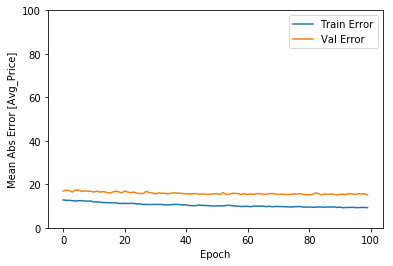

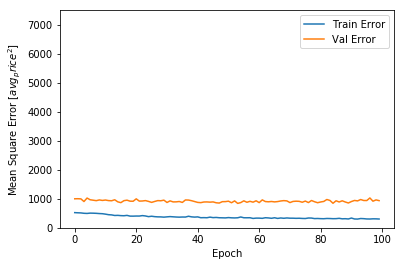

In [0]:
import matplotlib.pyplot as plt

def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch
  
  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error [Avg_Price]')
  plt.plot(hist['epoch'], hist['mean_absolute_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_absolute_error'],
           label = 'Val Error')
  plt.legend()
  plt.ylim([0,100])
  
  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error [$avg_price^2$]')
  plt.plot(hist['epoch'], hist['mean_squared_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_squared_error'],
           label = 'Val Error')
  plt.legend()
  plt.ylim([0,7500])

plot_history(history)


..................................................................................

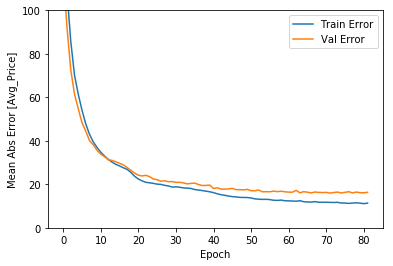

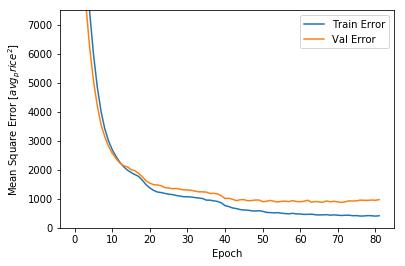

In [0]:
model = build_model()

# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

history = model.fit(normed_train_data, train_labels, epochs=EPOCHS,
                    validation_split = 0.2, verbose=0, callbacks=[early_stop, PrintDot()])

plot_history(history)

In [0]:
loss, mae, mse = model.evaluate(normed_test_data, test_labels, verbose=0)

print("Testing set Mean Abs Error: {:5.2f} USD".format(mae))

Testing set Mean Abs Error: 16.77 USD


In [0]:
test_predictions = model.predict(normed_test_data).flatten()

plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [Ticket Price]')
plt.ylabel('Predictions [Ticket Price]')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
_ = plt.plot([0, 700], [0, 700])

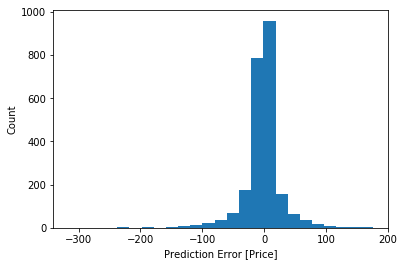

In [0]:


error = test_predictions - test_labels
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error [Price]")
_ = plt.ylabel("Count")